In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from keras.callbacks import ModelCheckpoint

In [15]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
test_generator = test_datagen.flow(x_test, y_test_cat, batch_size=64, shuffle=False)

In [5]:
# ResNet block
def resnet_block(x, filters, downsample=False, dropout_rate=0.3):
    shortcut = x
    stride = 2 if downsample else 1

    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    # Dropout after block (optional but added as you requested)
    x = layers.Dropout(dropout_rate)(x)

    return x

In [6]:
# Build ResNet-34 model
def build_resnet34(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    filters = 64
    block_counts = [3, 4, 6, 3]
    for i, num_blocks in enumerate(block_counts):
        for j in range(num_blocks):
            x = resnet_block(x, filters, downsample=(j == 0 and i != 0))
        filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

In [7]:
# Create and compile model
model = build_resnet34()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# create a callback to save the best weights during training
checkpointer = ModelCheckpoint(filepath='aug_model.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)

val_data = (x_val, y_val)
val_steps = len(x_val) // 64

# Train
history = model.fit(train_generator, validation_data=val_data, validation_steps=val_steps, epochs=10, callbacks=[checkpointer],)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1656 - loss: 2.6458

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 346.58939, saving model to aug_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 150ms/step - accuracy: 0.1657 - loss: 2.6452 - val_accuracy: 0.1206 - val_loss: 346.5894
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3580 - loss: 1.7327
Epoch 2: val_loss did not improve from 346.58939
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.3580 - loss: 1.7325 - val_accuracy: 0.0979 - val_loss: 1739.5602
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4470 - loss: 1.4983
Epoch 3: val_loss did not improve from 346.58939
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 137ms/step - accuracy: 0.4471 - loss: 1.4982 - val_accuracy: 0.0979 - val_loss: 1493.7832
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5249 - loss: 1.3075
Epoch 4: val_loss did not improve from 346.58939
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 138ms/step - accuracy: 0.5249 - loss: 1.3075 - val_accuracy: 0.0986 - val_loss: 977.2386
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5727 - loss: 1.1984
Epoch 5: val_loss did not improve from 346.58939
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.5727 - loss: 1.1984 - val_accuracy: 0.0979 - val_loss: 557.7667
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6180 - loss: 1.0836
Epoch 6: val_loss did not improve from 346.58939
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 137ms/step - accuracy: 0.6181 - loss: 1.0836 - val_accuracy: 0.0979 - val_loss: 388.5179
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6470 - loss: 1.0012
Epoch 7: val_loss improved from 346.58939 to 226.21053, saving model to aug_model.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 148ms/step - accuracy: 0.6470 - loss: 1.0011 - val_accuracy: 0.1127 - val_loss: 226.2105
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6718 - loss: 0.9443
Epoch 8: val_loss improved from 226.21053 to 159.07323, saving model to aug_model.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.6719 - loss: 0.9442 - val_accuracy: 0.1071 - val_loss: 159.0732
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6925 - loss: 0.8821
Epoch 9: val_loss did not improve from 159.07323
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 138ms/step - accuracy: 0.6925 - loss: 0.8820 - val_accuracy: 0.1138 - val_loss: 160.9759
Epoch 10/10
  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:41 163ms/step - accuracy: 0.7812 - loss: 0.7562

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7188 - loss: 0.8174
Epoch 10: val_loss improved from 159.07323 to 72.08704, saving model to aug_model.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.7188 - loss: 0.8174 - val_accuracy: 0.1753 - val_loss: 72.0870


In [9]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.h5')

In [10]:
# Evaluate
result = model.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7046 - loss: 0.8890


In [11]:
print("\n\nAccuracy on training set is {}".format(history.history["accuracy"][-1]))
print("\nAccuracy on test set is {}".format(result[1]))



Accuracy on training set is 0.7179750204086304

Accuracy on test set is 0.7003999948501587


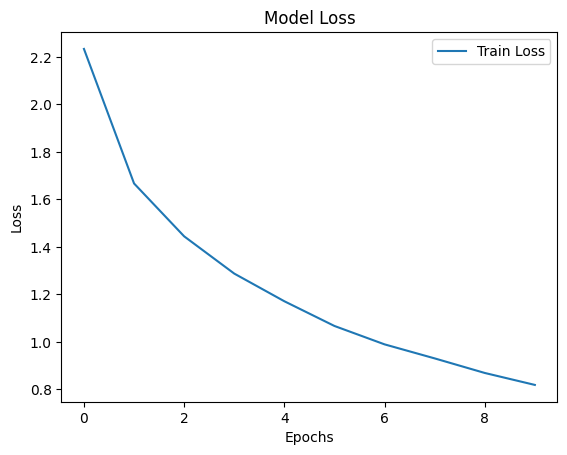

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

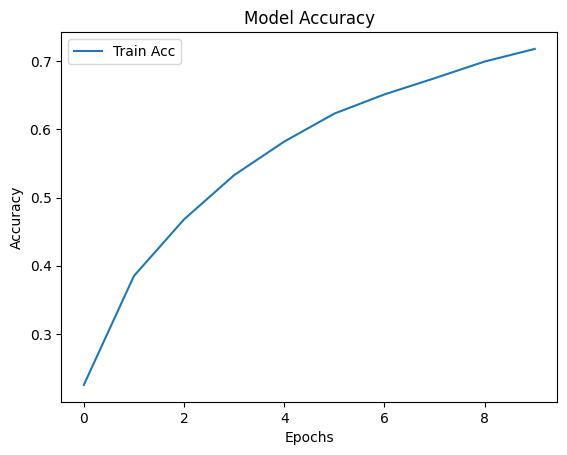

In [13]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step


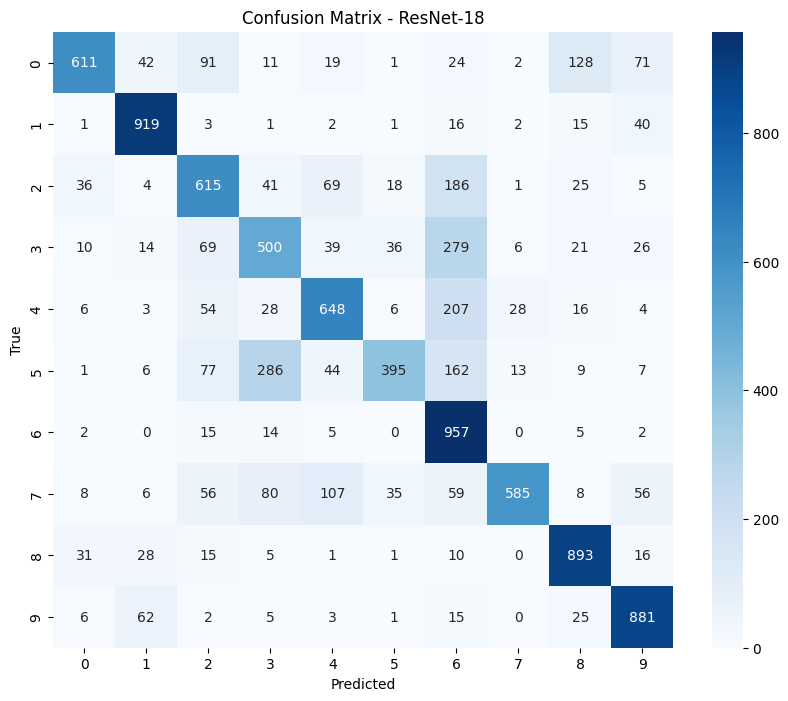

In [16]:
# Predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()


# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix - ResNet-18")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.61      0.71      1000
           1       0.85      0.92      0.88      1000
           2       0.62      0.61      0.62      1000
           3       0.51      0.50      0.51      1000
           4       0.69      0.65      0.67      1000
           5       0.80      0.40      0.53      1000
           6       0.50      0.96      0.66      1000
           7       0.92      0.58      0.71      1000
           8       0.78      0.89      0.83      1000
           9       0.80      0.88      0.84      1000

    accuracy                           0.70     10000
   macro avg       0.73      0.70      0.70     10000
weighted avg       0.73      0.70      0.70     10000

